In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gp
from geopandas import GeoDataFrame
from shapely.geometry import LineString
from shapely.geometry import MultiPoint
import shapely
import networkx as nx
import os.path
from os import path
import pathlib
import pandas as pd
from datetime import datetime
import numpy as np

import geopy.distance


from OSMPythonTools.api import Api as osm_api
ox.config(log_console=True, use_cache=True)

In [2]:
# Isochrone Maxspeed

start_point = (52.5153, 13.4040)
hours_of_day = range(24)
speed_aggregate = 'mean' # min, mean, max
local_set = False
path = 'travel_time+uberJan2020.graphml'

In [3]:
#G = ox.graph.graph_from_point(start_point, dist=dist, dist_type='network', network_type='drive')
#, simplify=True, retain_all=False, truncate_by_edge=False, clean_periphery=True, custom_filter=None)




In [4]:
if local_set:
    G = ox.graph.graph_from_place('Berlin, Germany', retain_all=True, buffer_dist=2500, network_type='drive')
    speed_df_orig = pd.read_csv('../data/Uber_speeds/movement-speeds-hourly-berlin-2020-1.csv')
else:
    G = ox.io.load_graphml(path)#, node_type=None, node_dtypes=None, edge_dtypes=None)
    

In [5]:
# Load Uber speeds into osm Graph

if speed_aggregate == 'min':
    speed_df = speed_df_orig.groupby(['osm_way_id','osm_start_node_id','osm_end_node_id']).min()['speed_kph_mean'].reset_index()
elif speed_aggregate == 'mean':
    speed_df = speed_df_orig.groupby(['osm_way_id','osm_start_node_id','osm_end_node_id']).mean()['speed_kph_mean'].reset_index()
elif speed_aggregate == 'max':
    speed_df = speed_df_orig.groupby(['osm_way_id','osm_start_node_id','osm_end_node_id']).max()['speed_kph_mean'].reset_index()

    
for way in speed_df.iloc():
    node_ids = [int(way['osm_start_node_id']),int(way['osm_end_node_id'])]
    try:
        G.edges[min(node_ids),max(node_ids),0]['real_speed'] = way['speed_kph_mean']
    except:
        pass


NameError: name 'speed_df_orig' is not defined

In [5]:
# Calculate Way Times for each Segment

for u, v, k, data in G.edges(data=True, keys=True):
    #print('maxspeed' in data.keys())
    if ('maxspeed' in data.keys()):
        #print(isinstance(data['maxspeed'], list))
        #print(data['maxspeed'])
        #print(type(data['maxspeed']))
        if(isinstance(data['maxspeed'], list)):
            
            
            #print(type(data['maxspeed']))
            #print(data['maxspeed'])
            speed = min(data['maxspeed'])
            #print(speed)
        else:
            speed = data['maxspeed']
    else:
        speed = 50.0
        
    if (speed == 'DE:urban'):
        speed = 50.0
    elif (speed == 'walk'):
        speed = 6.0
    elif (speed == 'none'):
        speed = 130.0
        
    #print(speed)    
    data['time'] = data['length'] / (float(speed) * 1000 / 60)
    data['maxspeed'] = float(speed)
    #print(data['test_maxspeed'])

    
    
    if ('real_speed' in data.keys()):
        real_speed = float(data['real_speed'])
    else:
        real_speed = speed
    data['real_time'] = data['length'] / (float(real_speed)* 1000 / 60)

ox.save_graphml(G, filepath='./travel_time+uberJan2020.graphml')

In [6]:
#nodes, edges = ox.graph_to_gdfs(G)
#set(list(edges['maxspeed'].values))

In [7]:
#center_node = ox.get_nearest_node(G, start_point)

#subgraph_15 = nx.ego_graph(G, center_node, radius=5, distance='time')
#subgraph_15_real = nx.ego_graph(G, center_node, radius=5, distance='real_time')

#ox.plot_graph(subgraph_15)
#ox.plot_graph(subgraph_15_real)



In [8]:
#nodes, edges = ox.graph_to_gdfs(subgraph_15_real)

#lat, long = MultiPoint(nodes.reset_index()['geometry']).convex_hull.exterior.coords.xy

#nodes['geometry'].plot()
#zip(lat,long)[0]

#MultiPoint(nodes.reset_index()['geometry']).convex_hull
    
#dist = [geopy.distance.geodesic(point,start_point).meters for point in zip(long,lat)]
#np.mean(dist)

In [9]:
#nodes, edges = ox.graph_to_gdfs()
#edges = edges.sort_values('time')
#nodes

In [127]:
def getAvgIsochroneDistStreet(start_point, travel_time_min, real_speed=True, plot_subgraph=False):
    x, y = Point(start_point).xy
    #print("y -> "+str(y))
    #print("x -> "+str(x))
    #start_point = [x,y]
    #print(start_point)
    center_node = ox.get_nearest_node(G, (y[0],x[0]))
    
    distance_type = 'real_time' if real_speed else 'time'
    
    subgraph = nx.ego_graph(G, center_node, radius=travel_time_min, distance=distance_type)
    
    if plot_subgraph:
        ox.plot_graph(subgraph)
    
    nodes, edges = ox.graph_to_gdfs(subgraph)

    lat, long = MultiPoint(nodes.reset_index()['geometry']).convex_hull.exterior.coords.xy
    #long, lat = MultiPoint(nodes.reset_index()['geometry']).convex_hull.exterior.coords.xy
    #dist = [geopy.distance.geodesic(point,start_point).meters for point in zip(long,lat)]
    dist = [geopy.distance.geodesic(point,start_point).meters for point in zip(lat,long)]
    
    return np.mean(dist)
    

In [128]:
#getAvgIsochroneDistStreet((52.617670, 13.223318), 5)
getAvgIsochroneDistStreet((13.223318, 52.617670), 5)

y -> array('d', [52.61767])
x -> array('d', [13.223318])


2741.3243554480105

In [129]:
def getAvgIsochroneDistStreet_list(list_of_points, travel_time_min):
    list_of_avg = []
    for point in list_of_points: 
        list_of_avg.append(getAvgIsochroneDistStreet(point, travel_time_min, real_speed=True, plot_subgraph=False))
    return list_of_avg

In [130]:
list_of_points = [(52.5652055, 13.3355015),
 (52.567033, 13.3466053),
 (52.567738, 13.3522545),
 (52.5640768, 13.339564),
 (52.5633975, 13.3429006),
 (52.5587807, 13.3373679),
 (52.5626152, 13.3306441),
 (52.5640457, 13.3277078),
 (52.5659103, 13.3202135),
 (52.5746796, 13.3460089),
 (52.573666, 13.3521078)]

In [131]:
list_of_points

[(52.5652055, 13.3355015),
 (52.567033, 13.3466053),
 (52.567738, 13.3522545),
 (52.5640768, 13.339564),
 (52.5633975, 13.3429006),
 (52.5587807, 13.3373679),
 (52.5626152, 13.3306441),
 (52.5640457, 13.3277078),
 (52.5659103, 13.3202135),
 (52.5746796, 13.3460089),
 (52.573666, 13.3521078)]

In [132]:
getAvgIsochroneDistStreet_list(list_of_points, 15)

y -> array('d', [13.3355015])
x -> array('d', [52.5652055])
y -> array('d', [13.3466053])
x -> array('d', [52.567033])
y -> array('d', [13.3522545])
x -> array('d', [52.567738])
y -> array('d', [13.339564])
x -> array('d', [52.5640768])
y -> array('d', [13.3429006])
x -> array('d', [52.5633975])
y -> array('d', [13.3373679])
x -> array('d', [52.5587807])
y -> array('d', [13.3306441])
x -> array('d', [52.5626152])
y -> array('d', [13.3277078])
x -> array('d', [52.5640457])
y -> array('d', [13.3202135])
x -> array('d', [52.5659103])
y -> array('d', [13.3460089])
x -> array('d', [52.5746796])
y -> array('d', [13.3521078])
x -> array('d', [52.573666])


[5523359.256129372,
 5522874.603449766,
 5522613.225183795,
 5523063.0567076085,
 5522836.165342448,
 5522832.621282967,
 5523452.918420729,
 5523707.658237695,
 5524239.716216956,
 5523412.94860589,
 5523013.424009835]

#  AvgIsoDistance of a PointList

In [133]:
samplepoints = gp.read_file("../results/sample-points.geojson")

<AxesSubplot:>

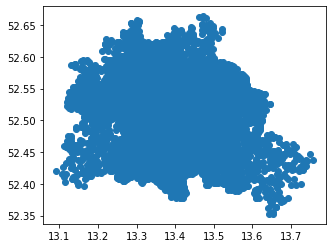

In [134]:
samplepoints.plot()

In [135]:
df = pd.read_json("../results/sample-points.json")

In [136]:
geodf = gp.GeoDataFrame(df)

In [137]:
#print(f'NumPy Array:\n{arr}')

list1 = df.values.tolist()


In [138]:
avg_iso_list = getAvgIsochroneDistStreet_list(list1, 5)

y -> array('d', [52.442944744460114])
x -> array('d', [13.161901338074973])
y -> array('d', [52.40198937293523])
x -> array('d', [13.148898817301504])
y -> array('d', [52.40332926172103])
x -> array('d', [13.146245476951975])
y -> array('d', [52.425968953045654])
x -> array('d', [13.133517862921396])
y -> array('d', [52.42246773174963])
x -> array('d', [13.19073265032867])
y -> array('d', [52.407967435141714])
x -> array('d', [13.135282531110501])
y -> array('d', [52.412995008206074])
x -> array('d', [13.179463536485974])
y -> array('d', [52.42038240346487])
x -> array('d', [13.09098099690146])
y -> array('d', [52.41363496114821])
x -> array('d', [13.17427618454405])


In [139]:
avg_iso_list

[2837.6579043388647,
 3094.084498788022,
 3208.976297993617,
 2750.6975706596036,
 4491.889788368286,
 1617.0576763053925,
 3409.845747860628,
 4334.702348841503,
 3617.1187248020797]

In [140]:
#geodf["avg_dist"] = avg_iso_list

ValueError: Length of values (9) does not match length of index (9900)